In [85]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
import json
import pandas as pd

import matplotlib.pyplot as plt
from copy import copy

In [87]:
def read_json(file: str) -> dict:
    with open(file, 'r') as f:
        dict_ = json.load(f)
    return dict_


In [88]:
infra = read_json('infra1.json')

In [89]:
routes = [route['id'] for route in infra['routes']]
routes

['rt.DA1->DA_out',
 'rt.buffer_stop.0->DA1',
 'rt.DA2->DA_out',
 'rt.buffer_stop.1->DA2',
 'rt.DA_out->DB_in',
 'rt.DB_in->DB2',
 'rt.DB_in->DB1',
 'rt.DB1->buffer_stop.2',
 'rt.DB2->buffer_stop.3']

In [90]:
routes_switches = {
    route['id']:list(route['switches_directions'].keys())[0] 
    for route in infra['routes']
    if len(list(route['switches_directions'].keys()))!=0
}

In [91]:
routes_switches

{'rt.DA1->DA_out': 'CVG',
 'rt.DA2->DA_out': 'CVG',
 'rt.DB_in->DB2': 'DVG',
 'rt.DB_in->DB1': 'DVG'}

In [92]:
sim = read_json('sim1.json')
res = read_json('res1.json')

In [93]:
sim.keys()

dict_keys(['train_schedules', 'train_succession_tables', 'rolling_stocks'])

In [94]:
sim['train_schedules'][1]['routes']

['rt.buffer_stop.1->DA2',
 'rt.DA2->DA_out',
 'rt.DA_out->DB_in',
 'rt.DB_in->DB2',
 'rt.DB2->buffer_stop.3']

In [95]:
from schedules import Schedule


In [96]:
routes = [route['id'] for route in infra['routes']]

s = Schedule(len(routes), len(sim['train_schedules']))

routes_switches = {
    route['id']:list(route['switches_directions'].keys())[0] 
    for route in infra['routes']
    if len(list(route['switches_directions'].keys()))!=0
}
simulations = 'base_simulations'
simulations = 'eco_simulations'

for train in range(s.num_trains):
    route_occupancies = res[train][simulations][0]['route_occupancies']
    for route, times in route_occupancies.items():
        idx = routes.index(route)
        s._df.loc[idx, (train, 's')] = times['time_head_occupy']
        s._df.loc[idx, (train, 'e')] = times['time_tail_free']
s._df.index = routes

s._df.index = pd.Series(s.df.index.map(routes_switches)).fillna(pd.Series(s.df.index))
s._df = s.df[~s.df.index.duplicated()]
s._df.index = s.df.index.str.replace('rt.','').str.replace('buffer_stop','STOP')


/tmp/ipykernel_931/3344794529.py:23: FutureWarning: The default value of regex will change from True to False in a future version.
  s._df.index = s.df.index.str.replace('rt.','').str.replace('buffer_stop','STOP')


In [97]:
s._df = s.df.sort_values(by=[(0,'s')])

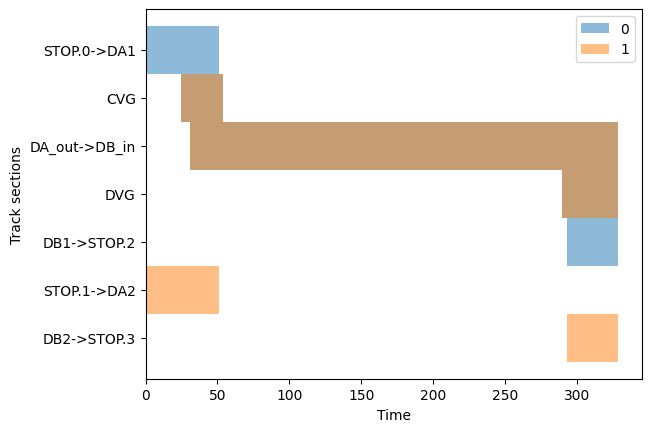

In [98]:
s.plot()

In [99]:
from regul_env import RegulEnv

In [100]:
env = RegulEnv(s, stations = ['DB1->STOP.2', 'DB2->STOP.3'])

In [101]:
env.reset(train=0, delay=0, track_section='STOP.0->DA1')

({'delayed_train': 0,
  'timetable': array([[0.0, 50.829, nan, nan],
         [24.993, 54.183, 24.993, 54.183],
         [31.034, 328.595, 31.034, 328.595],
         [289.464, 328.595, 289.464, 328.595],
         [293.105, 328.595, nan, nan],
         [nan, nan, 0.0, 50.829],
         [nan, nan, 293.105, 328.595]], dtype=object)},
 {})

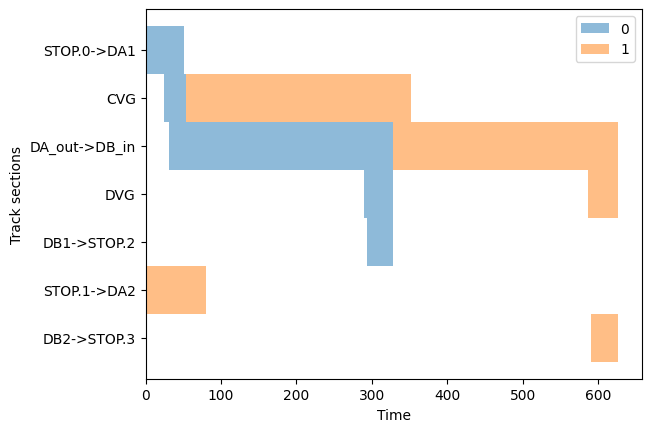

In [102]:
env.step(1)
env.render()

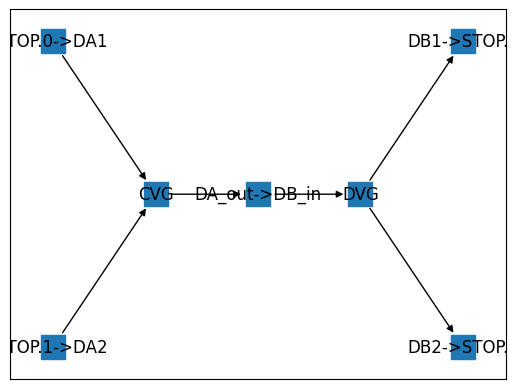

In [103]:
env.schedule.draw_graph()

In [104]:
base_head_positions = res[0]['base_simulations'][0]['head_positions']
eco_head_positions = res[0]['eco_simulations'][0]['head_positions']

t_base = [dict['time'] for dict in base_head_positions]
y_base = [dict['path_offset'] for dict in base_head_positions]
t_eco = [dict['time'] for dict in eco_head_positions]
y_eco = [dict['path_offset'] for dict in eco_head_positions]

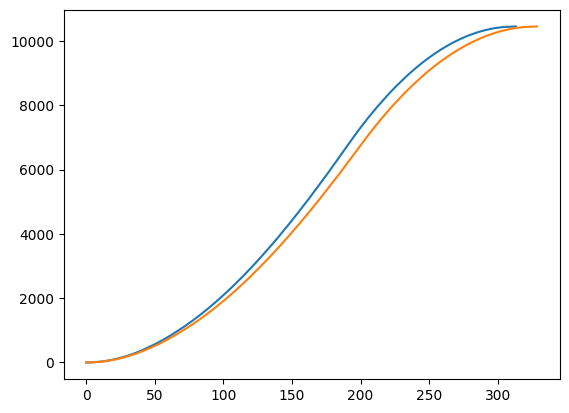

In [105]:
plt.plot(t_base, y_base, label='base')
plt.plot(t_eco, y_eco, label='eco')